# Beat detection and BPM tempo estimation

In this tutorial, we will show how to perform automatic [beat detection](https://en.wikipedia.org/wiki/Beat_detection) (beat tracking) and [tempo (BPM)](https://en.wikipedia.org/wiki/Tempo) estimation using different algorithms in Essentia.

## RhythmExtractor2013

We generally recommend using [RhythmExtractor2013](https://essentia.upf.edu/reference/std_RhythmExtractor2013.html) for beat and tempo estimation. This a wrapper algorithm providing two approaches, slower and more accurate `multifeature` vs. faster `degara`, using the auxiliary [BeatTrackerMultiFeature](https://essentia.upf.edu/reference/std_BeatTrackerMultiFeature.html) and [BeatTrackerDegara](https://essentia.upf.edu/reference/std_BeatTrackerDegara.html) for beat position estimation, respectively. 

The RhythmExtractor2013 algorithm outputs the estimated tempo (BPM), time positions of each beat, and confidence of their detection (in the case of using `multifeature`). In addition, it outputs the list of BPM estimates and periods between consecutive beats throughout the entire input audio signal. The algorithm relies on statistics gathered over the whole music track, and therefore it is not suited for real-time detection.

Similarly to our *onset detection tutorial*, to sonify the results, we mark the estimated beat positions in the audio, using [AudioOnsetsMarker](http://essentia.upf.edu/documentation/reference/std_AudioOnsetsMarker.html). To save the audio to a file, we use [MonoWriter](https://essentia.upf.edu/reference/std_MonoWriter.html). Consult that tutorial for more details.

In [1]:
import essentia.standard as es
from tempfile import TemporaryDirectory

# Loading an audio file.
audio = es.MonoLoader(filename='../../../test/audio/recorded/dubstep.flac')()

# Compute beat positions and BPM.
rhythm_extractor = es.RhythmExtractor2013(method="multifeature")
bpm, beats, beats_confidence, _, beats_intervals = rhythm_extractor(audio)

print("BPM:", bpm)
print("Beat positions (sec.):", beats)
print("Beat estimation confidence:", beats_confidence)

# Mark beat positions in the audio and write it to a file.
# Use beeps instead of white noise to mark them, as it is more distinctive.
marker = es.AudioOnsetsMarker(onsets=beats, type='beep')
marked_audio = marker(audio)

# Write to an audio file in a temporary directory.
temp_dir = TemporaryDirectory()
es.MonoWriter(filename=temp_dir.name + '/dubstep_beats.flac')(marked_audio)

BPM: 139.98114013671875
Beat positions (sec.): [0.42956915 0.8591383  1.3003174  1.7182766  2.1478457  2.577415
 2.9953742  3.4249432  3.8661225  4.2956915  4.7252607  5.15483
 5.584399   6.013968   6.431927  ]
Beat estimation confidence: 3.9443612098693848


We can now listen to the resulting audio with the beats marked by beeps. We can also visualize beat estimations.

In [2]:
import IPython
IPython.display.Audio(temp_dir.name + '/dubstep_beats.flac')

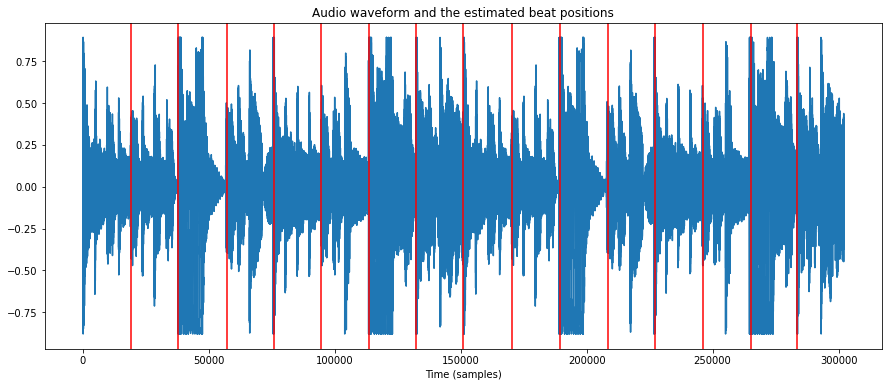

In [3]:
from pylab import plot, show, figure, imshow
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 6)

plot(audio)
for beat in beats:
    plt.axvline(x=beat*44100, color='red')
plt.xlabel('Time (samples)')
plt.title("Audio waveform and the estimated beat positions")
show()

## BPM histogram

The BPM value output by RhythmExtactor2013 is the average of all BPM estimates done for each interval between two consecutive beats. Alternatively, we can analyze the distribution of all those intervals using [BpmHistogramDescriptors](http://essentia.upf.edu/documentation/reference/std_BpmHistogramDescriptors.html). This is especially useful for music with a varying tempo (which is not the case in our example).

Overall BPM (estimated before): 140.0
First histogram peak: 140.0 bpm
Second histogram peak: 0.0 bpm


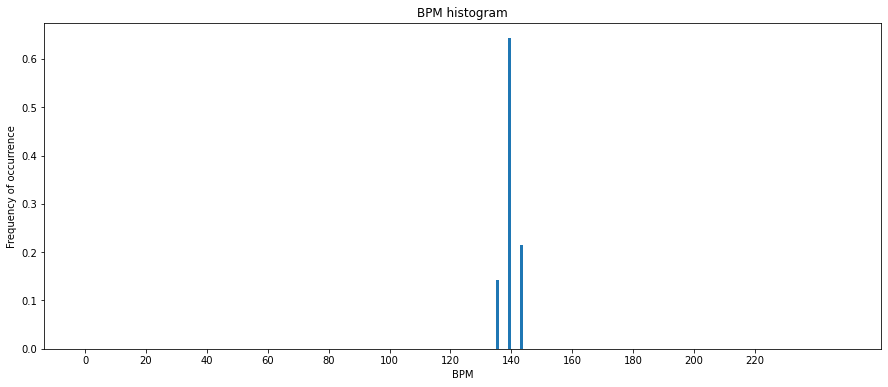

In [4]:
peak1_bpm, peak1_weight, peak1_spread, peak2_bpm, peak2_weight, peak2_spread, histogram = \
    es.BpmHistogramDescriptors()(beats_intervals)

print("Overall BPM (estimated before): %0.1f" % bpm)
print("First histogram peak: %0.1f bpm" % peak1_bpm)
print("Second histogram peak: %0.1f bpm" % peak2_bpm)

fig, ax = plt.subplots()
ax.bar(range(len(histogram)), histogram, width=1)
ax.set_xlabel('BPM')
ax.set_ylabel('Frequency of occurrence')
plt.title("BPM histogram")
ax.set_xticks([20 * x + 0.5 for x in range(int(len(histogram) / 20))])
ax.set_xticklabels([str(20 * x) for x in range(int(len(histogram) / 20))])
plt.show()

## BPM estimation with PercivalBpmEstimator

[PercivalBpmEstimator](https://essentia.upf.edu/reference/std_PercivalBpmEstimator.html) is another algorithm for tempo estimation.

In [5]:
# Loading an audio file.
audio = es.MonoLoader(filename='../../../test/audio/recorded/dubstep.flac')()

# Compute BPM.
bpm = es.PercivalBpmEstimator()(audio)

print("BPM:", bpm)

BPM: 140.14830017089844


## BPM estimation for audio loops

The BPM detection algorithms we considered so far won't necessarily produce the best estimation on short audio inputs, such as audio loops used in music production. Still, it is possible to apply some post-processing heuristics under the assumption that the analyzed audio loop is expected to be well-cut.

We have developed the [LoopBpmEstimator](https://essentia.upf.edu/reference/std_LoopBpmEstimator.html) algorithm specifically for the case of short audio loops. Based on PercivalBpmEstimator, it computes the likelihood of the correctness of BPM predictions using the duration of the audio loop as a reference. 

In [6]:
# Our input audio is indeed a well-cut loop. Let's compute the BPM.
bpm = es.LoopBpmEstimator()(audio)

print("Loop BPM:", bpm)

Loop BPM: 140.0


## BPM estimation with TempoCNN

Essentia supports inference with TensorFlow models for a variety of MIR tasks, in particular tempo estimation, for which we provide the `TempoCNN` models. 

The [TempoCNN](https://essentia.upf.edu/reference/std_TempoCNN.html) algorithm outputs a global BPM estimation on the entire audio input as well as local estimations on short audio segments (patches) throughout the track. For local estimations, it provides their probabilities that can be used as a confidence measure.

To use this algorithm in Python, follow [our instructions for using TensorFlow models](https://essentia.upf.edu/machine_learning.html#using-pre-trained-tensorflow-models).

To download the model:

In [7]:
!curl -SLO https://essentia.upf.edu/models/tempo/tempocnn/deeptemp-k16-3.pb

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1289k  100 1289k    0     0  8829k      0 --:--:-- --:--:-- --:--:-- 8829k


In [8]:
import essentia.standard as es

sr = 11025
audio_11khz = es.MonoLoader(filename='../../../test/audio/recorded/techno_loop.wav', sampleRate=sr)()

global_bpm, local_bpm, local_probs = es.TempoCNN(graphFilename='deeptemp-k16-3.pb')(audio_11khz)

print('song BPM: {}'.format(global_bpm))

song BPM: 125.0


We can plot a slice of the waveform on top of a grid with the estimated tempo to get visual verification

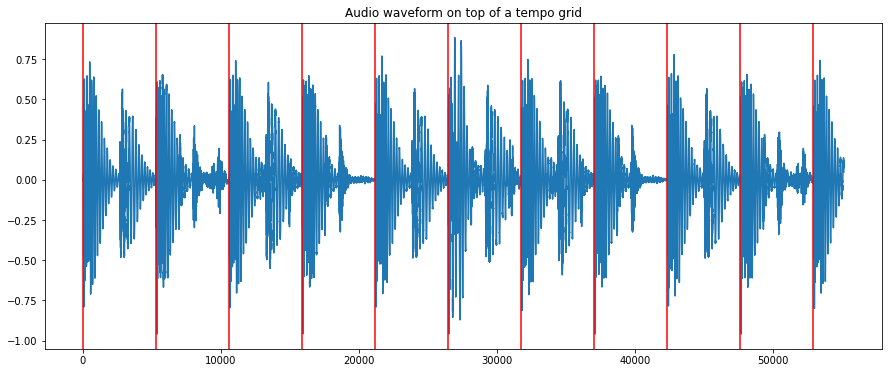

In [11]:
import numpy as np

duration = 5  # seconds
audio_slice = audio_11khz[:sr * duration]

plt.plot(audio_slice)
markers = np.arange(0, len(audio_slice), sr / (global_bpm / 60))
for marker in markers:
    plt.axvline(x=marker, color='red')
    
plt.title("Audio waveform on top of a tempo grid")
show()

`TempoCNN` operates on audio slices of 12 seconds with an overlap of 6 seconds by default. Additionally, the algorithm outputs the local estimations along with their probabilities. The global value is computed by majority voting by default. However, this method is only recommended when a constant tempo can be assumed.

In [16]:
print('local BPM: {}'.format(local_bpm))
print('local probabilities: {}'.format(local_probs))

local BPM: [125. 125. 125. 125.]
local probabilities: [0.9679363 0.9600502 0.9681525 0.9627014]
